# Explore, annotate, and analyze multi-dimensional images in Python with napari

## 1.1 – a *fast* 2D viewer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import napari

In [ ]:
import tifffile

image = tifffile.imread(
    '/Users/jni/projects/demos/spatialdata-sandbox/'
    'visium_io/data/Visium_Mouse_Olfactory_Bulb_image.tif'
)

In [ ]:
image.shape

In [ ]:
%matplotlib qt

In [ ]:
plt.imshow(image)

In [ ]:
viewer, layer = napari.imshow(image)

## 1.2 – a *multidimensional* viewer

### 3D multichannel cells

In [ ]:
from skimage import data

cells = data.cells3d()

cells.shape

In [ ]:
data.cells3d?

In [ ]:
plt.imshow(cells)

In [ ]:
viewer, layer = napari.imshow(
        cells,
        channel_axis=1,
        scale=[0.29, 0.26, 0.26],
        )

### CryoET Dynamo PCA analysis

Credit: Alister Burt (currently at Genentech)

In [ ]:
from pathlib import Path
from functools import cached_property

import pandas as pd
import numpy as np
import mrcfile


class DPCAA:
    def __init__(self, eigenvolumes_dir, eigentable_file):
        self.eigenvolumes_dir = Path(eigenvolumes_dir)
        self.eigentable_file = eigentable_file
    
    @cached_property
    def eigenvolumes(self):
        volume_files = list(self.eigenvolumes_dir.glob('*.mrc'))
        df = pd.DataFrame({'path' : volume_files}).sort_values(by='path')
        df['eigenvolume'] = df['path'].apply(lambda x: mrcfile.open(x).data)
        eigenvolumes = np.stack(df['eigenvolume'])
        return eigenvolumes

    @cached_property
    def eigentable(self):
        return np.loadtxt(self.eigentable_file, delimiter=',')

    def spectral_average_from_coefficients(self, coefficients, normalise=True):
        coefficients = coefficients.squeeze()[..., np.newaxis, np.newaxis, np.newaxis]
        spectral_average = (coefficients * self.eigenvolumes).sum(axis=-4)

        if normalise:
            spectral_average = self._normalise_volume(spectral_average)

        return spectral_average

    def spectral_average_from_idx(self, idx):
        """generate spectral average from particles at idx
        """
        coefficients = self._coefficients_from_idx(idx)
        return self.spectral_average_from_coefficients(coefficients)

    def _coefficients_from_idx(self, idx):
        """generate coefficients from a set of particles at idx
        """
        return self.eigentable[idx, :].sum(axis=0)

    def _generate_volume_series(self, eig, n_bins=10, qcut=True):
        eig_coefficients = self.eigentable[:, eig]

        if qcut:
            cut = pd.qcut(eig_coefficients, n_bins)
        else:
            cut = pd.cut(eig_coefficients, n_bins)

        volumes = [self.spectral_average_from_idx(cut == subset) for subset in cut.categories]
        return np.stack(volumes)

    def _generate_volume_series_vectorised(self, eig, n_bins=10, qcut=True):
        eig_coefficients = self.eigentable[:, eig]

        if qcut:
            cut = pd.qcut(eig_coefficients, n_bins)
        else:
            cut = pd.cut(eig_coefficients, n_bins)

        coefficients = np.stack(
            [self._coefficients_from_idx(cut == subset) for subset in cut.categories]
        )
        volumes = self.spectral_average_from_coefficients(coefficients)
        return volumes

    def _normalise_volume(self, volume):
        """independently normalise a stack of volumes to mean 0 standard deviation 1
        """
        volume_axes = (-1, -2, -3)
        volume_mean = np.expand_dims(volume.mean(axis=volume_axes), axis=volume_axes)
        volume_std = np.expand_dims(volume.std(axis=volume_axes), axis=volume_axes)
        return (volume - volume_mean) / volume_std


In [ ]:
from pathlib import Path

folder = Path('WM4196')
eigenvolumes = folder / 'eigenvolumes'
eigentable = folder / 'eigentable.csv'

pca = DPCAA(eigenvolumes_dir=eigenvolumes, eigentable_file=eigentable)

viewer = napari.Viewer()

n_bins = 10

volumes = np.stack([
        pca._generate_volume_series(comp, n_bins=n_bins, qcut=True)
        for comp in range(50)
        ])

viewer.add_image(volumes)

## 2 – a *layered* viewer

### overlay images, segmentations, point detections, and more

In [ ]:
from skimage import data

coins = data.coins()[50:-50, 50:-50]

viewer, im_layer = napari.imshow(coins)

In [ ]:
from skimage import filters, measure, morphology, segmentation

thresholded = filters.threshold_otsu(coins) < coins
closed = morphology.closing(thresholded, morphology.square(4))
no_border = segmentation.clear_border(closed)
cleaned = morphology.remove_small_objects(no_border, 20)

segmented = measure.label(cleaned).astype(np.uint8)

label_layer = viewer.add_labels(segmented)

In [ ]:
centroids = np.array([p.centroid for p in measure.regionprops(segmented)])
pts_layer = viewer.add_points(centroids, size=5)

In [ ]:
camera = data.camera()

viewer, im_layer = napari.imshow(camera)

In [ ]:
import pandas as pd

bboxes = [  # format: top left, bottom right
        [[67, 173], [201, 268]],
        [[111, 240], [220, 336]],
        ]

features = pd.DataFrame({
        'confidence': [100, 98.7221],
        'class': ['face', 'camera'],
        })

text_params = {
        'string': '{class}: {confidence:0.1f}%',  # f-string formatting
        'anchor': 'upper_left',
        'translation': [-5, 0],
        'size': 8,
        'color': 'magenta',
        }

shapes_layer = viewer.add_shapes(
        bboxes,
        features=features,
        edge_width=3,
        edge_color='magenta',
        face_color='transparent',
        text=text_params,
        name='detections',
        )


### cryoET particle picking refinement

Credit: Alister Burt (currently at Genentech)

Code: https://github.com/alisterburt/napari-cryo-et-demo  
Data: https://www.ebi.ac.uk/empiar/EMPIAR-10164/

In [ ]:
import mrcfile

# files containing data
tomogram_file = '/Users/jni/data/napari-cryo-et-demo/hiv/01_10.00Apx.mrc'
particles_file = '/Users/jni/data/napari-cryo-et-demo/hiv/01_10.00Apx_particles.star'

# loading data into memory
# tomogram is a numpy array containing image array data
with mrcfile.open(tomogram_file) as mrc:
    tomogram = mrc.data.copy()

viewer, tomo_layer = napari.imshow(
        tomogram,
        blending='translucent_no_depth',
        colormap='gray_r',
        )

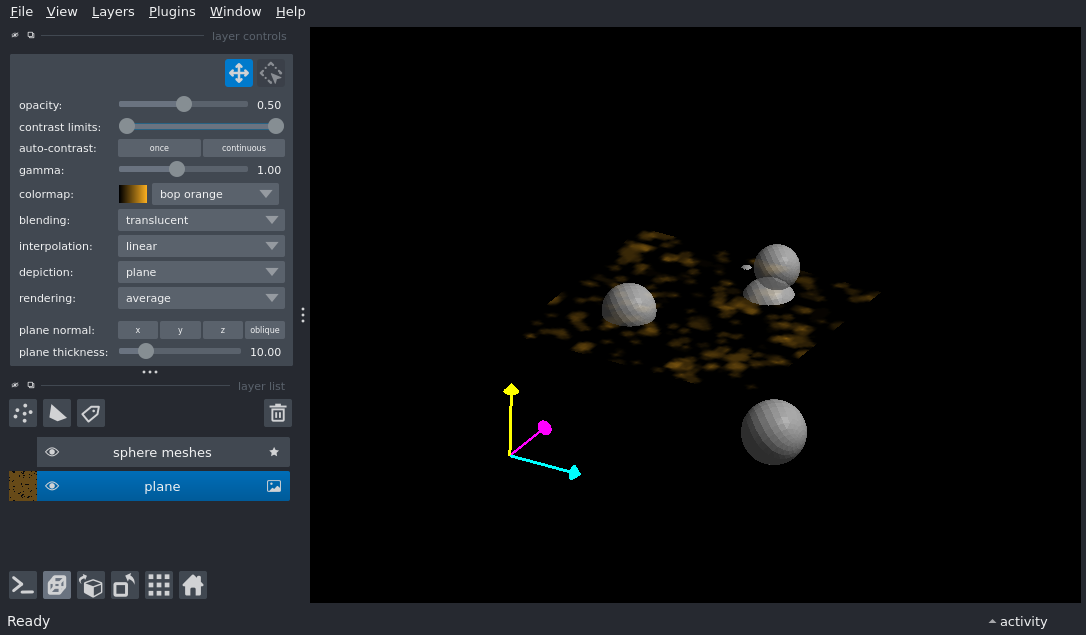

![sphere fitting](https://teamtomo.org/_images/hiv-oversampling1.png)

from https://teamtomo.org/walkthroughs/EMPIAR-10164/geometrical-picking.html

In [ ]:
import starfile
from scipy.spatial.transform import Rotation as R

# df is a pandas DataFrame containing table of info from STAR file
# including positions and orientations
df = starfile.read(particles_file)

# get particle positions as (n, 3) numpy array from DataFrame
zyx = df[
        ['rlnCoordinateZ', 'rlnCoordinateY', 'rlnCoordinateX']
        ].to_numpy()

pts_layer = viewer.add_points(
        zyx,
        face_color='cornflowerblue',
        size=10,
        )

In [ ]:
# get particle orientations as Euler angles from DataFrame
euler_angles = df[
        ['rlnAngleRot', 'rlnAngleTilt', 'rlnAnglePsi']
        ].to_numpy()

# turn Euler angles into a scipy 'Rotation' object, rotate Z vectors to see
# where they point for the aligned particle
rotations = R.from_euler(
        seq='ZYZ', angles=euler_angles, degrees=True
        ).inv()
direction_xyz = rotations.apply([0, 0, 1])
direction_zyx = direction_xyz[:, ::-1]

# set up napari vectors layer data
# (n, 2, 3) array
# dim 0: batch dimension
# dim 1: first row is start point of vector,
#        second is direction vector
# dim 2: components of direction vector e.g. (z, y, x)

vectors = np.stack((zyx, direction_zyx), axis=1)

vec_layer = viewer.add_vectors(
        vectors, length=10, edge_color='orange'
        )

![reconstruction](https://teamtomo.org/_images/result2.png)

from https://teamtomo.org/walkthroughs/EMPIAR-10164/m.html

## 3 – an *annotation* and *proofreading* tool

### interactive segmentation of 3D cells

Semi-automated methods in Python.

In [ ]:
viewer, (membrane_layer, nuclei_layer) = napari.imshow(
        cells,
        channel_axis=1,
        name=['membrane', 'nuclei'],
        )

In [ ]:
# grab individual channels and convert to float in [0, 1]

membranes = cells[:, 0, :, :] / np.max(cells)
nuclei = cells[:, 1, :, :] / np.max(cells)

In [ ]:
from skimage import filters


edges = filters.farid(nuclei)

edges_layer = viewer.add_image(
        edges,
        blending='additive',
        colormap='yellow',
        )

In [ ]:
from scipy import ndimage as ndi

denoised = ndi.median_filter(nuclei, size=3)

In [ ]:
li_thresholded = denoised > filters.threshold_li(denoised)

threshold_layer = viewer.add_image(
        li_thresholded,
        opacity=0.3,
        )

In [ ]:
from skimage import morphology

width = 20

holes_removed = morphology.remove_small_holes(
        li_thresholded, width ** 3
        )

speckle_removed = morphology.remove_small_objects(
        holes_removed, width ** 3
        )

viewer.layers[-1].visible = False

viewer.add_image(
        speckle_removed,
        name='cleaned',
        opacity=0.3,
        );

In [ ]:
from skimage import measure

labels = measure.label(speckle_removed)

viewer.layers[-1].visible = False
viewer.add_labels(
        labels,
        opacity=0.5,
        blending='translucent_no_depth'
        )


In [ ]:
# Sean's solution
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

spacing = [0.29, 0.26, 0.26]
distances = ndi.distance_transform_edt(
    speckle_removed, sampling=spacing
)
dt_smoothed = filters.gaussian(distances, sigma=5)
peaks = peak_local_max(dt_smoothed, min_distance=5)

pts_layer = viewer.add_points(
        peaks,
        name="sean's points",
        size=4,
        n_dimensional=True,  # points have 3D "extent"
        )

In [ ]:
points_data = pts_layer.data
points_data

In [ ]:
from skimage import segmentation, util

markers = util.label_points(points_data, nuclei.shape)
markers_big = morphology.dilation(markers, morphology.ball(5))

segmented = segmentation.watershed(
        edges, markers_big, mask=speckle_removed,
        )

seg_layer = viewer.add_labels(
        segmented, blending='translucent_no_depth',
        )

viewer.layers['labels'].visible = False

## 4.1 – a *lazy* viewer

Tribolium castaneum light sheet microscopy data from the [Cell tracking challenge](http://celltrackingchallenge.net/3d-datasets/) contributed by Akanksha Jain, MPI-CBG Dresden.

In [ ]:
import zarr

image = zarr.open('/Users/jni/data/Fluo-N3DL-TRIF/01.ome.zarr/0/')

print(f'{image.nbytes / 1e9:.0f}GB')

In [ ]:
print(image.shape)

In [ ]:
print(image.chunks)

In [ ]:
viewer, layer = napari.imshow(image)

In [ ]:
layer.contrast_limits

In [ ]:
layer.contrast_limits = 1000, 6000

In [ ]:
layer.colormap = 'magma'

## 4.2 – a *multiscale* viewer

In [ ]:
image1 = zarr.open('/Users/jni/data/Fluo-N3DL-TRIF/01.ome.zarr/1/')
image2 = zarr.open('/Users/jni/data/Fluo-N3DL-TRIF/01.ome.zarr/2/')

viewer, layer = napari.imshow(
        [image, image1, image2],
        rendering='attenuated_mip',
        name='tribolium',
        )

In [ ]:
layer.contrast_limits = 1000, 6000

## 4.3 – lazy annotation 🦥🎨, thank you zarr! 🧊❤️🙏

In [ ]:
type(image), image.shape, image.nbytes / 1e9

In [ ]:
viewer = napari.Viewer()
layer_multi = viewer.add_image(
        [image, image1, image2],
        rendering='attenuated_mip',
        name='tribolium',
        )

labels = zarr.open(
        '/Users/jni/data/Fluo-N3DL-TRIF/01-labels.zarr',
        dtype=np.uint32,
        shape=image.shape,
        write_empty_chunks=False,
        chunks=image.chunks,
        )

In [ ]:
!ls -a /Users/jni/data/Fluo-N3DL-TRIF/

In [ ]:
!ls -a /Users/jni/data/Fluo-N3DL-TRIF/01-labels.zarr

In [ ]:
labels.shape

In [ ]:
layer = viewer.add_labels(labels)

In [ ]:
!ls -a /Users/jni/data/Fluo-N3DL-TRIF/01-labels.zarr

In [ ]:
!rm -rf /Users/jni/data/Fluo-N3DL-TRIF/01-labels.zarr

## 5 – plays well with others

napariboard

In [ ]:
!python /Users/jni/projects/napariboard-proto/napariboard.py

## 6 – extensible with plugins

## napari-ome-zarr

In [ ]:
viewer = napari.Viewer()

In [ ]:
viewer.open(
        '/Users/jni/data/Fluo-N3DL-TRIF/01.ome.zarr',
        plugin='napari-ome-zarr',
        )

napari-pdf-reader (I shit you not 😂)

In [ ]:
viewer = napari.Viewer()

pdf_layer, = viewer.open('data/project_jupyter.pdf', plugin='napari-pdf-reader')

In [ ]:
from skimage import color

pdfbw = color.rgb2gray(pdf_layer.data)
pdf_layer.visible = False
pdfbw_layer = viewer.add_image(
        pdfbw[:, ::2, ::2],
        scale=(2, 2, 2),
        rendering='translucent',
        )
viewer.dims.ndisplay = 3

In [ ]:
from magicgui import magicgui, widgets

@magicgui(
        shear={'widget_type': widgets.FloatSlider,
               'min': 0,
               'max': pdfbw.shape[1]},
        auto_call=True,
        )
def set_layer_xz_shear(shear: float):
    pdfbw_layer.affine = [
            [1    , 0, 0, 0],
            [0    , 1, 0, 0],
            [shear, 0, 1, 0],
            [0    , 0, 0, 1],
            ]

dw = viewer.window.add_dock_widget(set_layer_xz_shear);